In [1]:
import pyarrow.dataset as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load Datasets

In [3]:
# define dataset
dataset = ds.dataset(
    "/Users/bobet/Documents/Code Repository/Trading-Systems/_datasets",
    format="parquet")

# push filter into Arrow scan (faster, uses partition pruning if possible)
table = dataset.to_table(filter=ds.field("symbol") == "BTCUSDT")

# convert to pandasssss
df = table.to_pandas()
df.tail()

,symbol,ts_ms,iso_utc,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,...,tr_volume_base,tr_volume_quote,tr_vwap,tr_buy_sell_imbalance,spot_price,perp_mark_price,basis_abs,basis_pct,funding_rate,next_funding_time_ms
20426,BTCUSDT,1756696863112,2025-09-01T03:21:03.112632+00:00,1756696860000,107498.57,107534.57,107498.57,107534.56,1.75518,1756696919999,...,14.13011,1.519354e+06,107525.982814,-0.235795,107534.57,107493.3,-41.27,-0.000384,0.000098,1756713600000
20427,BTCUSDT,1756696923162,2025-09-01T03:22:03.162639+00:00,1756696920000,107489.44,107509.19,107489.44,107500.43,6.83290,1756696979999,...,9.94524,1.070096e+06,107598.856226,-0.247065,107494.69,107461.1,-33.59,-0.000312,0.000098,1756713600000
20428,BTCUSDT,1756696983212,2025-09-01T03:23:03.212623+00:00,1756696980000,107540.77,107540.78,107540.77,107540.77,3.04218,1756697039999,...,11.87618,1.277630e+06,107579.189836,-0.119993,107540.77,107506.5,-34.27,-0.000319,0.000099,1756713600000
20429,BTCUSDT,1756697043262,2025-09-01T03:24:03.262631+00:00,1756697040000,107498.18,107508.25,107498.17,107508.25,0.38007,1756697099999,...,4.46384,4.802759e+05,107592.551552,-0.868105,107508.25,107465.2,-43.05,-0.000400,0.000099,1756713600000
20430,BTCUSDT,1756697103312,2025-09-01T03:25:03.312627+00:00,1756697100000,107447.45,107447.45,107447.44,107447.45,0.03028,1756697159999,...,6.21923,6.685749e+05,107501.227448,-0.424964,107447.44,107415.4,-32.04,-0.000298,0.000099,1756713600000


In [4]:
#features
df.columns

Index(['symbol', 'ts_ms', 'iso_utc', 'ohlc_ts_open', 'ohlc_open', 'ohlc_high',
       'ohlc_low', 'ohlc_close', 'ohlc_volume', 'ohlc_ts_close', 'ohlc_trades',
       'ohlc_taker_base', 'ohlc_taker_quote', 'l1_bid', 'l1_ask', 'l1_mid',
       'l1_spread', 'l1_bid_qty', 'l1_ask_qty', 'l1_imbalance', 'l2_bid_depth',
       'l2_ask_depth', 'l2_depth_asymmetry', 'l2_bid_vwap', 'l2_ask_vwap',
       'l2_bid_slope', 'l2_ask_slope', 'tr_volume_base', 'tr_volume_quote',
       'tr_vwap', 'tr_buy_sell_imbalance', 'spot_price', 'perp_mark_price',
       'basis_abs', 'basis_pct', 'funding_rate', 'next_funding_time_ms'],
      dtype='object')

## Data hygiene & storage

✔ Why: storage efficiency + ordering. A 10GB dataset may shrink to ~3-4GB when optimized.

In [ ]:
# Ensure correct dtypes (saves memory on 10GB dataset)
dtype_map = {
    "symbol": "category",
    "ohlc_open": "float32", "ohlc_high": "float32", "ohlc_low": "float32", "ohlc_close": "float32",
    "ohlc_volume": "float32", "ohlc_trades": "int32",
    "ohlc_taker_base": "float32", "ohlc_taker_quote": "float32",
    "l1_bid": "float32", "l1_ask": "float32", "l1_mid": "float32", "l1_spread": "float32",
    "l1_bid_qty": "float32", "l1_ask_qty": "float32", "l1_imbalance": "float32",
    "l2_bid_depth": "float32", "l2_ask_depth": "float32", "l2_depth_asymmetry": "float32",
    "l2_bid_vwap": "float32", "l2_ask_vwap": "float32",
    "l2_bid_slope": "float32", "l2_ask_slope": "float32",
    "tr_volume_base": "float32", "tr_volume_quote": "float32", "tr_vwap": "float32",
    "tr_buy_sell_imbalance": "float32",
    "spot_price": "float32", "perp_mark_price": "float32",
    "basis_abs": "float32", "basis_pct": "float32", "funding_rate": "float32"
}

df = df.astype(dtype_map)

# Make sure timestamp is datetime
df["iso_utc"] = pd.to_datetime(df["iso_utc"])
df = df.set_index("iso_utc").sort_index()
df.tail()

,symbol,ts_ms,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,ohlc_trades,...,tr_volume_base,tr_volume_quote,tr_vwap,tr_buy_sell_imbalance,spot_price,perp_mark_price,basis_abs,basis_pct,funding_rate,next_funding_time_ms
iso_utc,,,,,,,,,,,,,,,,,,,,,
2025-08-17 15:45:47.575950+00:00,BTCUSDT,1755445547575,1755445500000,118248.593750,118251.351562,118248.578125,118251.351562,0.75580,1755445559999,242,...,4.56246,539297.3750,118203.203125,0.488706,118251.343750,118195.445312,-55.892235,-0.000473,0.000017,1755446400000
2025-08-17 15:46:47.606265+00:00,BTCUSDT,1755445607606,1755445560000,118251.351562,118251.351562,118234.523438,118234.531250,5.14589,1755445619999,671,...,5.28487,624816.4375,118227.398438,0.327650,118234.531250,118174.101562,-60.430000,-0.000511,0.000017,1755446400000
2025-08-17 15:47:47.643040+00:00,BTCUSDT,1755445667643,1755445620000,118234.523438,118234.531250,118234.523438,118234.531250,2.35213,1755445679999,180,...,5.56556,658036.6250,118233.671875,0.493460,118234.523438,118189.703125,-44.820000,-0.000379,0.000017,1755446400000
2025-08-17 15:48:47.662644+00:00,BTCUSDT,1755445727662,1755445680000,118234.531250,118234.531250,118234.523438,118234.523438,6.03409,1755445739999,314,...,7.24521,856689.0625,118242.132812,-0.299805,118234.523438,118184.718750,-49.797905,-0.000421,0.000017,1755446400000
2025-08-17 15:49:47.702649+00:00,BTCUSDT,1755445787702,1755445740000,118234.531250,118234.531250,118234.523438,118234.523438,1.28289,1755445799999,163,...,7.78536,920561.1875,118242.601562,-0.385300,118234.523438,118180.898438,-53.619999,-0.000454,0.000017,1755446400000


## Integrity checks

✔ Why: many exchange feeds can have glitches (negative vols, wrong highs/lows).

In [5]:
# Drop duplicates, check ordering
df = df[~df.index.duplicated(keep="first")].sort_index()

# Sanity checks for OHLC
mask = (
    (df["ohlc_low"] <= df["ohlc_open"]) &
    (df["ohlc_low"] <= df["ohlc_close"]) &
    (df["ohlc_high"] >= df["ohlc_open"]) &
    (df["ohlc_high"] >= df["ohlc_close"])
)
df = df[mask]

# Check non-negative volumes
df = df[df["ohlc_volume"] >= 0]

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20431 entries, 2025-08-17 15:45:47.575950+00:00 to 2025-09-01 03:25:03.312627+00:00
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   symbol                 20431 non-null  category
 1   ts_ms                  20431 non-null  int64   
 2   ohlc_ts_open           20431 non-null  int64   
 3   ohlc_open              20431 non-null  float32 
 4   ohlc_high              20431 non-null  float32 
 5   ohlc_low               20431 non-null  float32 
 6   ohlc_close             20431 non-null  float32 
 7   ohlc_volume            20431 non-null  float32 
 8   ohlc_ts_close          20431 non-null  int64   
 9   ohlc_trades            20431 non-null  int32   
 10  ohlc_taker_base        20431 non-null  float32 
 11  ohlc_taker_quote       20431 non-null  float32 
 12  l1_bid                 20431 non-null  float32 
 13  l1_ask                 20431 n

# Exploratory Data analysis (EDA)

## Price levels (log price)

- AFML emphasizes non-stationarity; plotting log price immediately shows regime shifts, bubbles, drawdowns, and whether you should avoid modeling the level directly and instead model returns or differences.

- López de Prado uses `log prices` instead of raw prices because financial assets evolve through compounding, meaning changes are proportional rather than absolute. A $100 move matters very differently when Bitcoin is at $1,000 versus at $60,000. By taking the logarithm of prices, proportional changes become additive, exponential growth phases become linear, and returns can be expressed simply as differences of log prices. This makes the data scale-invariant, easier to visualize, and statistically more suitable for modeling, while raw prices remain non-stationary and misleading for direct analysis.

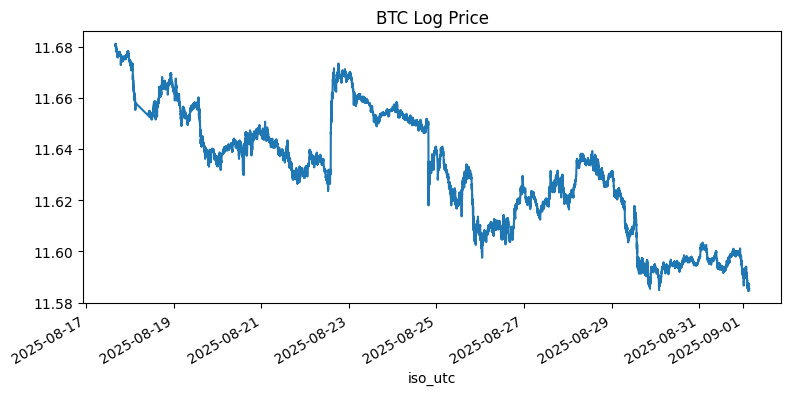

In [6]:
# Create log price and log returns
df["logp"] = np.log(df["ohlc_close"])
df["ret"]  = df["logp"].diff()

# Drop the first NaN return
df = df.dropna(subset=["ret"])

df["logp"].plot(title="BTC Log Price", figsize=(9,4))
plt.show()

## Log returns (core object of analysis)

- Most AFML pipelines build on log returns.

- Identifying glitches avoids contaminating downstream stats or labels (e.g., triple-barrier).

- López de Prado (and most of finance) focuses on log returns instead of raw or simple returns because they turn the multiplicative process of compounding into an additive one. With log returns, the total return over multiple periods is just the sum of individual log returns, which simplifies analysis and modeling. They are also scale-invariant (a doubling in price is the same whether Bitcoin goes from $100 to $200 or $10,000 to $20,000), and they approximate continuously compounded returns used in quantitative finance. This makes log returns more mathematically tractable, closer to stationary than prices, and the natural input for machine learning models in AFML.

- López de Prado (and most of finance) focuses log returns because they measure percentage changes in a way that’s consistent over time. They make big and small price moves comparable (a doubling always gives the same log return), they add up nicely across time, and they are closer to being stationary than prices. This makes them easier to analyze and much better suited for models in financial machine learning.

- In financial machine learning, log returns are the foundation for both features and labels, which makes them essential for model training. Features are typically built from transformations of log returns, such as rolling volatility, momentum, skewness, or autocorrelations, because returns are closer to stationary and capture market dynamics more consistently than raw prices. Labels, such as those created with the triple-barrier method, directional up/down signals, or meta-labeling, are also defined in terms of log returns, since they directly reflect proportional price movements and compounding effects. By working with log returns, the model avoids distortions from raw price trends, aligns naturally with risk metrics like Sharpe ratio or drawdowns, and learns from statistically meaningful signals that map directly to trading decisions.

- `Extreme return points`, or `outliers`, are return values that are unusually large or small compared to the rest of the dataset. Their purpose in exploratory analysis is to flag either bad data (errors, misrecorded ticks) or rare but real events (flash crashes, sudden rallies, exchange outages). Identifying them is highly relevant in financial machine learning because outliers can distort statistical measures, create misleading labels, and cause models to overfit noise rather than learn robust patterns. In Advances in Financial Machine Learning, Marcos López de Prado emphasizes that poor data quality is one of the main causes of failed strategies; he recommends cleaning or correcting data errors while using robust statistical methods that can handle genuine extreme events without letting them dominate the learning process. In practice, that means inspecting extreme return points, removing those caused by data glitches, but keeping true market shocks and designing models (e.g., with robust estimators, heavy-tailed assumptions, or clipping) that can learn from them appropriately.

In [7]:
# Quick sanity: extreme jumps (possible data glitches)
q = df["ret"].quantile([0.001, 0.999])
extreme_mask = (df["ret"] < q.iloc[0]) | (df["ret"] > q.iloc[1])
print("Extreme return points:", extreme_mask.sum())

# (Optional) clip truly bad ticks while keeping fat tails
df["ret_clipped"] = df["ret"].clip(lower=q.iloc[0], upper=q.iloc[1])

Extreme return points: 42


## Summary statistics

- Annualized mean/vol translate raw return stats into portfolio-relevant terms.

- Skew and excess kurtosis reveal asymmetry and fat tails—central to AFML (normality is a poor assumption in crypto).

In [8]:
# Infer frequency to annualize (works for regular intervals)
freq = pd.infer_freq(df.index)  # returns e.g. 'T' for 1-min, 'H' for 1-hour
# Map a few common freqs; adjust if needed
per_year = {
    "T": 60*24*365,   # 1-min
    "5T": 12*24*365,  # 5-min
    "15T": 4*24*365,  # 15-min
    "30T": 2*24*365,  # 30-min
    "H": 24*365,      # hourly
    "D": 365,         # daily
}.get(freq, np.nan)

mu = df["ret"].mean()
sigma = df["ret"].std()
skew = stats.skew(df["ret"], bias=False)
ex_kurt = stats.kurtosis(df["ret"], fisher=True, bias=False)  # excess kurtosis

ann_mu = mu * per_year if np.isfinite(per_year) else np.nan
ann_vol = sigma * np.sqrt(per_year) if np.isfinite(per_year) else np.nan

summary = pd.Series({
    "freq_detected": freq,
    "mean_ret": mu,
    "vol_ret": sigma,
    "skew": skew,
    "excess_kurtosis": ex_kurt,
    "annualized_mean": ann_mu,
    "annualized_vol": ann_vol
})
print(summary.round(6))

freq_detected            NaN
mean_ret           -0.000005
vol_ret             0.000487
skew               -1.862434
excess_kurtosis    88.218460
annualized_mean          NaN
annualized_vol           NaN
dtype: float64


## Distribution Diagnostics

Visual confirmation of heavy tails and deviations from Gaussianity guides model choice (e.g., robust estimators, heavy-tailed distributions, robust risk metrics).


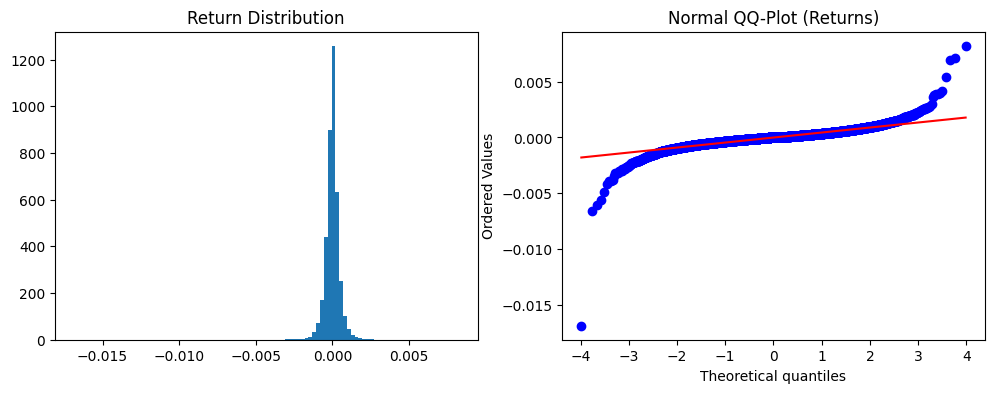

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Histogram
ax[0].hist(df["ret"], bins=100, density=True)
ax[0].set_title("Return Distribution")

# Normal QQ-plot
stats.probplot(df["ret"], dist="norm", plot=ax[1])
ax[1].set_title("Normal QQ-Plot (Returns)")

plt.show()

## Stationarity Tests

- AFML often targets stationary inputs (or transformations).

- ADF & KPSS together give a balanced view: returns are usually closer to stationary than prices; if not, consider fractional differencing later.

In [10]:
# ADF: H0 = unit root (non-stationary)
adf_stat, adf_p, *_ = adfuller(df["ret"].dropna(), autolag="AIC")

# KPSS: H0 = stationary
kpss_stat, kpss_p, *_ = kpss(df["ret"].dropna(), regression="c", nlags="auto")

print(f"ADF: stat={adf_stat:.4f}, p={adf_p:.4g}  |  KPSS: stat={kpss_stat:.4f}, p={kpss_p:.4g}")

ADF: stat=-20.9363, p=0  |  KPSS: stat=0.0514, p=0.1


/var/folders/ql/hgmmtv9908b7mbkg3586_cym0000gn/T/ipykernel_7520/4181364692.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(df["ret"].dropna(), regression="c", nlags="auto")


## Autocorrelation Structure

- Returns often show little linear autocorrelation (weak predictability).
- Squared returns show strong autocorrelation (volatility clustering), informing volatility models, event-based sampling, and label holding periods.

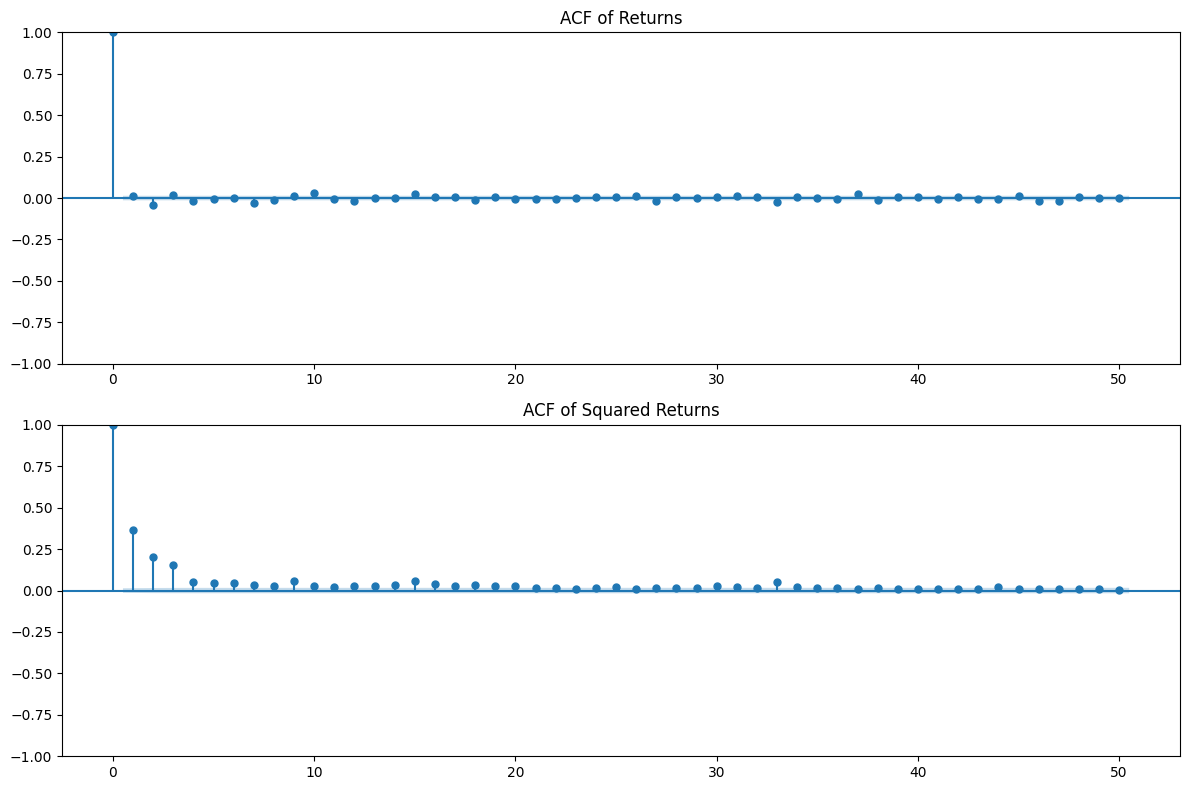

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))

# ACF of returns
plot_acf(df["ret"].dropna(), lags=50, ax=ax[0])
ax[0].set_title("ACF of Returns")

# ACF of squared returns
plot_acf((df["ret"]**2).dropna(), lags=50, ax=ax[1])
ax[1].set_title("ACF of Squared Returns")

plt.tight_layout()
plt.show()

## Rolling volatility (clustering & regime changes)

- Volatility regimes affect label horizons (triple-barrier), risk sizing, and walk-forward splits.

- AFML stresses non-stationary risk; rolling vol quantifies it.

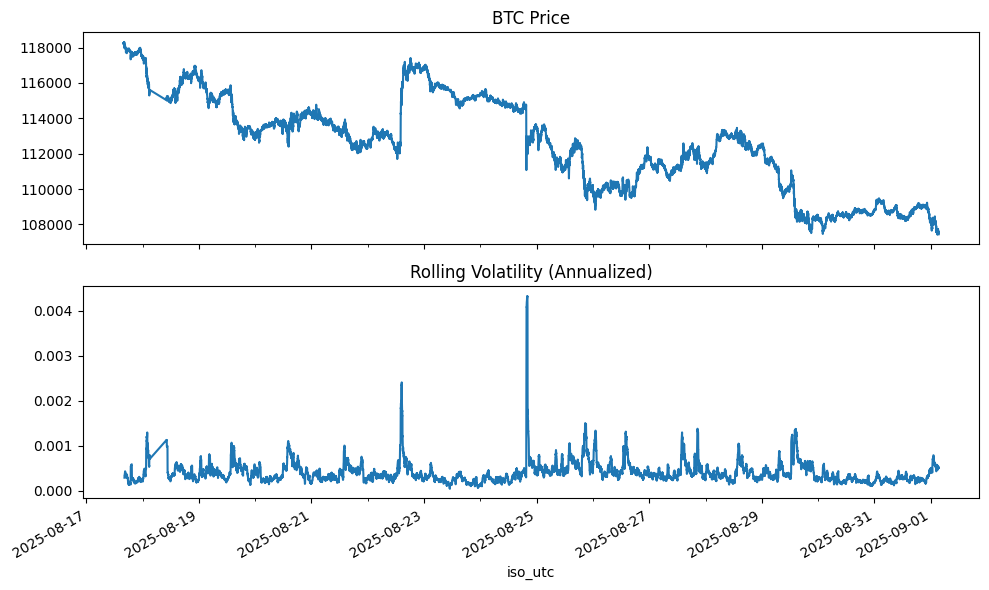

In [12]:
win = 288 if freq=="5T" else (24*30 if freq=="H" else 30)  # heuristic: ~1 trading month
rolling_vol = df["ret"].rolling(win).std()

# Annualize if per_year is known
rolling_vol_annual = rolling_vol * (np.sqrt(per_year) if np.isfinite(per_year) else 1.0)

fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
df["ohlc_close"].plot(ax=ax[0], title="BTC Price")
rolling_vol_annual.plot(ax=ax[1], title="Rolling Volatility (Annualized)")
plt.tight_layout(); plt.show()

## Volume/turnover relations

- Crypto often shows a volume–volatility link.
- If volume proxies for information flow/liquidity, it can guide event-driven sampling (sample when volume/vol exceeds thresholds).

Corr(returns, volume) = -0.1384
Contemporaneous Corr(volume, |ret|) = 0.5253


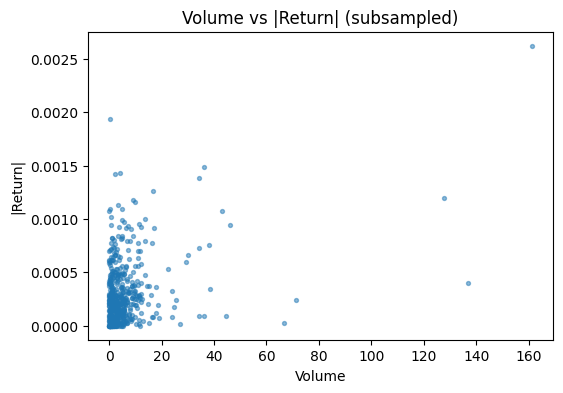

In [13]:
# Basic correlation
corr = df[["ret","ohlc_volume"]].corr().iloc[0,1]
print("Corr(returns, volume) =", round(corr, 4))

# Lagged relation: does volume lead volatility?
df["abs_ret"] = df["ret"].abs()
lead_lag = df[["ohlc_volume","abs_ret"]].rolling(1).mean().corr().iloc[0,1]
print("Contemporaneous Corr(volume, |ret|) =", round(lead_lag, 4))

# Simple scatter (subsample for readability)
sample = df.iloc[::max(len(df)//500,1)]
plt.figure(figsize=(6,4))
plt.scatter(sample["ohlc_volume"], sample["abs_ret"], s=8, alpha=0.5)
plt.title("Volume vs |Return| (subsampled)")
plt.xlabel("Volume"); plt.ylabel("|Return|")
plt.show()

## Intraday seasonality (for intraday data)

- Seasonality (by hour/UTC) is strong in crypto (region-specific activity).

- Helps time-normalize features, avoid spurious signals, and decide when to trade.

/var/folders/ql/hgmmtv9908b7mbkg3586_cym0000gn/T/ipykernel_7520/3258054081.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  if (df.index[1] - df.index[0]) <= pd.Timedelta("1H"):


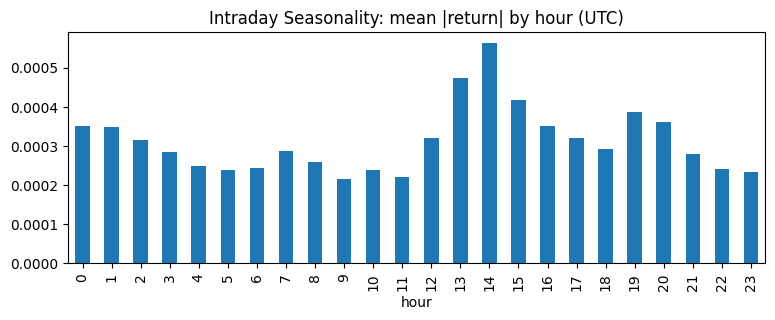

In [14]:
if df.index.freq is None:
    # Resample to ensure uniform spacing if needed (choose your base freq)
    # df = df.resample("5T").last().dropna()
    pass

if (df.index[1] - df.index[0]) <= pd.Timedelta("1H"):
    intraday = df.copy()
    intraday["hour"] = intraday.index.hour
    season = intraday.groupby("hour")["ret"].apply(lambda x: x.abs().mean())
    season.plot(kind="bar", figsize=(9,3), title="Intraday Seasonality: mean |return| by hour (UTC)")
    plt.show()

# Sampling

### Event-based sampling (information bars)

Instead of fixed 1-minute bars, AFML recommends sampling by information flow. Example: Dollar bars.

✔ Why: produces bars that adapt to market activity → fewer bars in quiet periods, more in active.


In [15]:
def get_dollar_bars(df, threshold=1e6):
    """Aggregate trades until $ threshold is met, then form a bar."""
    bars = []
    cum_dollar = 0
    open_, high_, low_ = None, -np.inf, np.inf
    volume = 0
    
    for ts, row in df.iterrows():
        price, vol = row["ohlc_close"], row["ohlc_volume"]
        dollar = price * vol
        if open_ is None:
            open_ = price
        cum_dollar += dollar
        volume += vol
        high_ = max(high_, row["ohlc_high"])
        low_ = min(low_, row["ohlc_low"])
        
        if cum_dollar >= threshold:
            bars.append({
                "time": ts,
                "open": open_, "high": high_, "low": low_, "close": price,
                "volume": volume, "cum_dollar": cum_dollar
            })
            open_, high_, low_, volume, cum_dollar = None, -np.inf, np.inf, 0, 0
    return pd.DataFrame(bars).set_index("time")

dollar_bars = get_dollar_bars(df, threshold=1e6)

dollar_bars.head()

,open,high,low,close,volume,cum_dollar
time,,,,,,
2025-08-17 15:48:47.662644+00:00,118234.531250,118251.351562,118234.523438,118234.523438,13.53211,1.599963e+06
2025-08-17 15:51:47.722647+00:00,118234.523438,118234.531250,118211.328125,118211.328125,10.78225,1.274687e+06
2025-08-17 15:57:47.842653+00:00,118211.328125,118263.898438,118211.328125,118263.898438,9.60767,1.136122e+06
2025-08-17 16:00:47.962789+00:00,118263.890625,118294.117188,118246.148438,118294.117188,11.27153,1.333155e+06
2025-08-17 16:03:48.072656+00:00,118304.000000,118304.640625,118225.703125,118225.710938,18.43035,2.179490e+06


## Volatility estimation

✔ Why: vol is critical for barrier labeling and normalizing SMC features.

In [16]:
# Use exponential weighted volatility
returns = df["ohlc_close"].pct_change()
df["ewm_vol"] = returns.ewm(span=50).std()

# Optional: Parkinson volatility (requires high/low)
df["parkinson_vol"] = np.sqrt((1 / (4*np.log(2))) * (np.log(df["ohlc_high"]/df["ohlc_low"]))**2)

df.head()

,symbol,ts_ms,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,ohlc_trades,...,basis_abs,basis_pct,funding_rate,next_funding_time_ms,logp,ret,ret_clipped,abs_ret,ewm_vol,parkinson_vol
iso_utc,,,,,,,,,,,,,,,,,,,,,
2025-08-17 15:46:47.606265+00:00,BTCUSDT,1755445607606,1755445560000,118251.351562,118251.351562,118234.523438,118234.531250,5.14589,1755445619999,671,...,-60.430000,-0.000511,0.000017,1755446400000,11.680426,-0.000142,-0.000142,0.000142,NaN,8.547533e-05
2025-08-17 15:47:47.643040+00:00,BTCUSDT,1755445667643,1755445620000,118234.523438,118234.531250,118234.523438,118234.531250,2.35213,1755445679999,180,...,-44.820000,-0.000379,0.000017,1755446400000,11.680426,0.000000,0.000000,0.000000,NaN,7.159247e-08
2025-08-17 15:48:47.662644+00:00,BTCUSDT,1755445727662,1755445680000,118234.531250,118234.531250,118234.523438,118234.523438,6.03409,1755445739999,314,...,-49.797905,-0.000421,0.000017,1755446400000,11.680426,0.000000,0.000000,0.000000,4.214685e-08,7.159247e-08
2025-08-17 15:49:47.702649+00:00,BTCUSDT,1755445787702,1755445740000,118234.531250,118234.531250,118234.523438,118234.523438,1.28289,1755445799999,163,...,-53.619999,-0.000454,0.000017,1755446400000,11.680426,0.000000,0.000000,0.000000,3.441735e-08,7.159247e-08
2025-08-17 15:50:47.712668+00:00,BTCUSDT,1755445847712,1755445800000,118234.523438,118234.531250,118234.523438,118234.531250,3.17160,1755445859999,269,...,-53.490726,-0.000452,0.000017,1755446400000,11.680426,0.000000,0.000000,0.000000,7.617103e-08,7.159247e-08


## Fractional differentiation (AFML Ch. 5)

Preserve memory but make series stationary.

✔ Why: prevents spurious regression by ensuring near-stationarity.

In [17]:
def frac_diff(series, d, thresh=1e-5):
    """Fractionally differentiate a series."""
    # compute weights
    w, k = [1.], 1
    while abs(w[-1]) > thresh:
        w_ = -w[-1] * (d - k + 1) / k
        w.append(w_)
        k += 1
    w = np.array(w[::-1]).reshape(-1, 1)
    # apply
    df_ = pd.Series(np.nan, index=series.index)
    for iloc in range(len(w), len(series)):
        df_.iloc[iloc] = np.dot(w.T, series.iloc[iloc-len(w):iloc])[0]
    return df_

df["fd_close"] = frac_diff(df["ohlc_close"], d=0.4)

df.head()

,symbol,ts_ms,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,ohlc_trades,...,basis_pct,funding_rate,next_funding_time_ms,logp,ret,ret_clipped,abs_ret,ewm_vol,parkinson_vol,fd_close
iso_utc,,,,,,,,,,,,,,,,,,,,,
2025-08-17 15:46:47.606265+00:00,BTCUSDT,1755445607606,1755445560000,118251.351562,118251.351562,118234.523438,118234.531250,5.14589,1755445619999,671,...,-0.000511,0.000017,1755446400000,11.680426,-0.000142,-0.000142,0.000142,NaN,8.547533e-05,NaN
2025-08-17 15:47:47.643040+00:00,BTCUSDT,1755445667643,1755445620000,118234.523438,118234.531250,118234.523438,118234.531250,2.35213,1755445679999,180,...,-0.000379,0.000017,1755446400000,11.680426,0.000000,0.000000,0.000000,NaN,7.159247e-08,NaN
2025-08-17 15:48:47.662644+00:00,BTCUSDT,1755445727662,1755445680000,118234.531250,118234.531250,118234.523438,118234.523438,6.03409,1755445739999,314,...,-0.000421,0.000017,1755446400000,11.680426,0.000000,0.000000,0.000000,4.214685e-08,7.159247e-08,NaN
2025-08-17 15:49:47.702649+00:00,BTCUSDT,1755445787702,1755445740000,118234.531250,118234.531250,118234.523438,118234.523438,1.28289,1755445799999,163,...,-0.000454,0.000017,1755446400000,11.680426,0.000000,0.000000,0.000000,3.441735e-08,7.159247e-08,NaN
2025-08-17 15:50:47.712668+00:00,BTCUSDT,1755445847712,1755445800000,118234.523438,118234.531250,118234.523438,118234.531250,3.17160,1755445859999,269,...,-0.000452,0.000017,1755446400000,11.680426,0.000000,0.000000,0.000000,7.617103e-08,7.159247e-08,NaN


## Market microstructure features (for later SMC detectors)
•	Order book imbalance: already present as l1_imbalance, l2_depth_asymmetry.

•	Effective spread proxy:

In [18]:
df["eff_spread"] = df["l1_ask"] - df["l1_bid"]
df["rel_spread"] = df["eff_spread"] / df["l1_mid"]
df.head()

,symbol,ts_ms,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,ohlc_trades,...,next_funding_time_ms,logp,ret,ret_clipped,abs_ret,ewm_vol,parkinson_vol,fd_close,eff_spread,rel_spread
iso_utc,,,,,,,,,,,,,,,,,,,,,
2025-08-17 15:46:47.606265+00:00,BTCUSDT,1755445607606,1755445560000,118251.351562,118251.351562,118234.523438,118234.531250,5.14589,1755445619999,671,...,1755446400000,11.680426,-0.000142,-0.000142,0.000142,NaN,8.547533e-05,NaN,0.007812,6.607630e-08
2025-08-17 15:47:47.643040+00:00,BTCUSDT,1755445667643,1755445620000,118234.523438,118234.531250,118234.523438,118234.531250,2.35213,1755445679999,180,...,1755446400000,11.680426,0.000000,0.000000,0.000000,NaN,7.159247e-08,NaN,0.007812,6.607630e-08
2025-08-17 15:48:47.662644+00:00,BTCUSDT,1755445727662,1755445680000,118234.531250,118234.531250,118234.523438,118234.523438,6.03409,1755445739999,314,...,1755446400000,11.680426,0.000000,0.000000,0.000000,4.214685e-08,7.159247e-08,NaN,0.007812,6.607630e-08
2025-08-17 15:49:47.702649+00:00,BTCUSDT,1755445787702,1755445740000,118234.531250,118234.531250,118234.523438,118234.523438,1.28289,1755445799999,163,...,1755446400000,11.680426,0.000000,0.000000,0.000000,3.441735e-08,7.159247e-08,NaN,0.007812,6.607630e-08
2025-08-17 15:50:47.712668+00:00,BTCUSDT,1755445847712,1755445800000,118234.523438,118234.531250,118234.523438,118234.531250,3.17160,1755445859999,269,...,1755446400000,11.680426,0.000000,0.000000,0.000000,7.617103e-08,7.159247e-08,NaN,0.007812,6.607630e-08


Volume Imbalance:

In [19]:
df["vol_imbalance"] = (df["l1_bid_qty"] - df["l1_ask_qty"]) / (df["l1_bid_qty"] + df["l1_ask_qty"])

df.head()

,symbol,ts_ms,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,ohlc_trades,...,logp,ret,ret_clipped,abs_ret,ewm_vol,parkinson_vol,fd_close,eff_spread,rel_spread,vol_imbalance
iso_utc,,,,,,,,,,,,,,,,,,,,,
2025-08-17 15:46:47.606265+00:00,BTCUSDT,1755445607606,1755445560000,118251.351562,118251.351562,118234.523438,118234.531250,5.14589,1755445619999,671,...,11.680426,-0.000142,-0.000142,0.000142,NaN,8.547533e-05,NaN,0.007812,6.607630e-08,-0.302139
2025-08-17 15:47:47.643040+00:00,BTCUSDT,1755445667643,1755445620000,118234.523438,118234.531250,118234.523438,118234.531250,2.35213,1755445679999,180,...,11.680426,0.000000,0.000000,0.000000,NaN,7.159247e-08,NaN,0.007812,6.607630e-08,0.251794
2025-08-17 15:48:47.662644+00:00,BTCUSDT,1755445727662,1755445680000,118234.531250,118234.531250,118234.523438,118234.523438,6.03409,1755445739999,314,...,11.680426,0.000000,0.000000,0.000000,4.214685e-08,7.159247e-08,NaN,0.007812,6.607630e-08,-0.751128
2025-08-17 15:49:47.702649+00:00,BTCUSDT,1755445787702,1755445740000,118234.531250,118234.531250,118234.523438,118234.523438,1.28289,1755445799999,163,...,11.680426,0.000000,0.000000,0.000000,3.441735e-08,7.159247e-08,NaN,0.007812,6.607630e-08,-0.383406
2025-08-17 15:50:47.712668+00:00,BTCUSDT,1755445847712,1755445800000,118234.523438,118234.531250,118234.523438,118234.531250,3.17160,1755445859999,269,...,11.680426,0.000000,0.000000,0.000000,7.617103e-08,7.159247e-08,NaN,0.007812,6.607630e-08,-0.718298


In [20]:
# define dataset
dataset = ds.dataset("./parquet_dataset", format="parquet")

# push filter into Arrow scan (faster, uses partition pruning if possible)
table = dataset.to_table(filter=ds.field("symbol") == "BTCUSDT")

# convert to pandasssss
df = table.to_pandas()
df.head()

,symbol,ts_ms,iso_utc,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,...,tr_volume_base,tr_volume_quote,tr_vwap,tr_buy_sell_imbalance,spot_price,perp_mark_price,basis_abs,basis_pct,funding_rate,next_funding_time_ms
0,BTCUSDT,1755422910793,2025-08-17T09:28:30.793863+00:00,1755422880000,118378.76,118378.76,118344.21,118344.21,4.32934,1755422939999,...,5.20579,6.163562e+05,118398.211898,-0.213015,118344.21,118282.663521,-61.546479,-0.000520,0.000040,1755446400000
1,BTCUSDT,1755422970798,2025-08-17T09:29:30.798716+00:00,1755422940000,118360.00,118360.00,118350.50,118350.50,0.50453,1755422999999,...,6.03546,7.145173e+05,118386.555944,-0.569733,118350.51,118292.400000,-58.110000,-0.000491,0.000040,1755446400000
2,BTCUSDT,1755423030802,2025-08-17T09:30:30.802430+00:00,1755423000000,118344.62,118387.37,118344.62,118359.20,5.17591,1755423059999,...,7.66860,9.076058e+05,118353.515664,0.248121,118359.20,118299.324667,-59.875333,-0.000506,0.000040,1755446400000
3,BTCUSDT,1755423090807,2025-08-17T09:31:30.807200+00:00,1755423060000,118372.13,118376.09,118348.03,118376.09,3.36768,1755423119999,...,9.53290,1.128365e+06,118365.387977,0.264085,118376.08,118315.200000,-60.880000,-0.000514,0.000039,1755446400000
4,BTCUSDT,1755423150807,2025-08-17T09:32:30.807585+00:00,1755423120000,118355.31,118355.32,118331.31,118331.32,3.19415,1755423179999,...,10.68027,1.264277e+06,118375.046007,-0.252401,118331.31,118263.200000,-68.110000,-0.000576,0.000038,1755446400000
